In [10]:
import torch 
import torch.nn as nn
import os 
import sys
# Get the absolute path of the project root
project_root = os.path.abspath("..")  # Adjust if needed

# Add the project root to sys.path
if project_root not in sys.path:
    sys.path.append(project_root)

from proteinshake.datasets import ProteinLigandInterfaceDataset, AlphaFoldDataset, GeneOntologyDataset, ProteinFamilyDataset
from src.utils import data_utils as dtu
from torch.utils.data import DataLoader, Dataset, Subset
from src.models.basicVae import LitBasicVae
# from src.models.basicVae_pyt import BasicVae
import numpy as np
from src.dataset_classes.sequenceDataset import *
from sklearn.model_selection import KFold
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
dataset = ProteinFamilyDataset(root='../data').to_point().torch()

In [12]:
import random

indices = list(range(100))  # Example list of indices
subset_size = 10  # Size of the random subset

random_subset = random.sample(indices, subset_size)  # Get random subset
remaining_subset = list(set(indices) - set(random_subset))  # Get remaining indices

print("Random Subset:", random_subset)
print("Remaining Subset:", remaining_subset)

Random Subset: [76, 38, 87, 6, 68, 53, 86, 18, 56, 13]
Remaining Subset: [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 54, 55, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 69, 70, 71, 72, 73, 74, 75, 77, 78, 79, 80, 81, 82, 83, 84, 85, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]


In [13]:
idx_list = range(len(dataset))
subset_size = int(len(dataset)//10)
val_idx = random.sample(idx_list, subset_size)  # Get random subset
train_idx = list(set(idx_list) - set(val_idx))

In [14]:
s = 500
train_subset = SequenceDataset(Subset(dataset, train_idx), s)
val_subset = SequenceDataset(Subset(dataset, val_idx), s)

100%|██████████| 3110/3110 [00:00<00:00, 3239.88it/s]


In [99]:
latent_dim = 32
epochs = 100
lr = 0.001
batch_size = 256
train_dataloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_subset,batch_size=batch_size, shuffle=False)
x_dim = train_subset[0].shape[0]
if torch.cuda.is_available():
    torch.cuda.current_device()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [112]:
model = LitBasicVae(latent_dim = latent_dim, 
                    seq_len = s, hidden_dim = 1024, 
                    amino_acids = 21, optimizer=torch.optim.Adam, 
                    optimizer_param={'lr':0.001}, dropout = 0.0, reconstruction_loss_weight = 1, beta = 0.01, 
                    beta_increment = 0, 
                    beta_epoch_start = 20,
                    beta_cycle = 30)
model

LitBasicVae(
  (tanh): Tanh()
  (soft): Softmax(dim=2)
  (dropout_layer): Dropout(p=0.0, inplace=False)
  (fc1_enc): Linear(in_features=10500, out_features=1024, bias=True)
  (fc3_enc_mean): Linear(in_features=1024, out_features=32, bias=True)
  (fc3_enc_logvar): Linear(in_features=1024, out_features=32, bias=True)
  (fc1_dec): Linear(in_features=32, out_features=1024, bias=True)
  (fc3_dec): Linear(in_features=1024, out_features=10500, bias=True)
)

In [113]:
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import EarlyStopping
import pytorch_lightning as pl
optimizer = torch.optim.Adam
optimizer_param = {'lr':0.001}
trainer = pl.Trainer(max_epochs=epochs,
    accelerator="auto",
    devices="auto",
    logger=TensorBoardLogger(save_dir="logs/"))
# model = LitBasicVae(latent_dim, x_dim, optimizer, optimizer_param,)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [114]:
trainer.fit(model, train_dataloader, val_dataloader)


  | Name           | Type    | Params | Mode 
---------------------------------------------------
0 | tanh           | Tanh    | 0      | train
1 | soft           | Softmax | 0      | train
2 | dropout_layer  | Dropout | 0      | train
3 | fc1_enc        | Linear  | 10.8 M | train
4 | fc3_enc_mean   | Linear  | 32.8 K | train
5 | fc3_enc_logvar | Linear  | 32.8 K | train
6 | fc1_dec        | Linear  | 33.8 K | train
7 | fc3_dec        | Linear  | 10.8 M | train
---------------------------------------------------
21.6 M    Trainable params
0         Non-trainable params
21.6 M    Total params
86.460    Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

# Model Visualisation

In [55]:
dataset = ProteinFamilyDataset(root = '../data').to_point().torch()

In [84]:
# Load the trained model from checkpoint
checkpoint_path = "../trained_models/Pfam/optimise_bvae/00-23-03_Pfam_BasicVAE_study_BS128_MS500_trials50/39_LD256_HD1024_Beta0.1.ckpt"
model = LitBasicVae.load_from_checkpoint(checkpoint_path)

# Put model in evaluation mode
model.eval()


LitBasicVae(
  (tanh): Tanh()
  (soft): Softmax(dim=2)
  (dropout_layer): Dropout(p=0, inplace=False)
  (fc1_enc): Linear(in_features=10500, out_features=1024, bias=True)
  (fc3_enc_mean): Linear(in_features=1024, out_features=256, bias=True)
  (fc3_enc_logvar): Linear(in_features=1024, out_features=256, bias=True)
  (fc1_dec): Linear(in_features=256, out_features=1024, bias=True)
  (fc3_dec): Linear(in_features=1024, out_features=10500, bias=True)
)

In [44]:
input = next(iter(train_dataloader))
model.to('cpu')

LitBasicVae(
  (tanh): Tanh()
  (soft): Softmax(dim=2)
  (dropout_layer): Dropout(p=0.0, inplace=False)
  (fc1_enc): Linear(in_features=10500, out_features=512, bias=True)
  (fc3_enc_mean): Linear(in_features=512, out_features=64, bias=True)
  (fc3_enc_logvar): Linear(in_features=512, out_features=64, bias=True)
  (fc1_dec): Linear(in_features=64, out_features=512, bias=True)
  (fc3_dec): Linear(in_features=512, out_features=10500, bias=True)
)

In [45]:
reparam_z, x_mu, x_logvar, x_rec, logit = model(input)

In [62]:
input[10].argmax(dim=-1) == x_rec[10].argmax(dim=-1)

tensor([ True,  True,  True,  True,  True,  True,  True, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,  True,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,  True,
        False, False, False, False, False,  True, False, False, False, False,
        False, False, False,  True, False, False, False, False, 

tensor([16, 19, 10, 11,  5,  0, 16, 10,  9, 10,  0,  0, 15,  7, 15, 16, 16,  1,
        11, 10, 10, 10,  7,  7,  7,  5,  5, 13, 16,  0, 10, 10, 19, 19, 10, 19,
        10,  0,  7,  5, 11, 16,  7,  0,  5,  7,  0,  0,  0,  0, 10,  0, 11,  3,
        19,  0,  0, 10, 11, 10,  5, 19,  5,  0,  5,  5,  5, 10,  5, 10, 10, 10,
        10,  5,  1,  7, 11,  0,  0,  7,  7, 10,  7,  3,  0, 11, 19,  0,  0, 10,
         7, 10, 10, 10, 19, 10,  0, 10, 10,  0,  0, 10,  0, 11,  0,  0, 19, 10,
        19, 10,  1, 10, 10, 10, 11, 10,  5,  0,  6,  0,  0,  0, 10,  0,  0,  0,
        11, 10,  0,  0, 10, 10, 10, 10,  5, 15, 19, 19, 15,  0, 10,  7, 19, 19,
        10,  0,  9,  9, 19, 19, 10,  3,  7, 10,  0, 10,  3,  9,  0,  3,  0,  0,
         0, 16,  0, 10, 10,  0, 10, 19, 10,  5,  3,  0,  2,  0,  0,  0,  9,  1,
         0,  0, 10,  9, 10,  0,  7, 19,  9,  5, 10,  9, 15, 16, 14, 15, 15, 10,
         5, 12,  7,  7,  0,  0,  9, 10,  0,  9, 16, 19,  7,  6, 16, 15, 13, 19,
         5,  7,  7,  7,  7, 11,  7,  7, 

In [47]:
for i in range(128):
    print(torch.where(x_rec[i].argmax(dim=-1) == 20))

(tensor([470, 471, 481, 488, 493, 494, 497]),)
(tensor([475, 477, 485, 497, 498, 499]),)
(tensor([258, 423, 458, 464, 497, 498, 499]),)
(tensor([498, 499]),)
(tensor([331, 374, 478, 489, 494, 496, 499]),)
(tensor([443, 484, 486, 487, 494, 498, 499]),)
(tensor([444, 484, 485, 491, 494, 496, 497, 498]),)
(tensor([320, 456, 474, 483, 488, 497, 498, 499]),)
(tensor([ 36, 419, 424, 467, 488, 492, 494, 499]),)
(tensor([330, 397, 459, 489, 493, 498, 499]),)
(tensor([293, 319, 428, 441, 456, 460, 463, 464, 487, 492, 493, 494, 499]),)
(tensor([411, 432, 498, 499]),)
(tensor([433, 476, 486, 493, 497]),)
(tensor([448, 482, 494, 495, 497, 499]),)
(tensor([ 80, 321, 357, 410, 424, 476, 495, 497, 498, 499]),)
(tensor([393, 421, 490, 493, 498, 499]),)
(tensor([271, 276, 357, 407, 421, 459, 472, 474, 483, 488, 490, 499]),)
(tensor([129, 306, 391, 416, 424, 428, 444, 446]),)
(tensor([357, 389, 418, 433, 461, 491, 498]),)
(tensor([293, 312, 409, 451, 474, 478, 484, 485, 493, 494, 499]),)
(tensor([219, 2

In [30]:
seq_dataset = SequenceDataset(dataset, 500, return_proteins=True)
seq_dataloader = DataLoader(seq_dataset, batch_size= 256, shuffle = False)

100%|██████████| 31109/31109 [00:07<00:00, 4315.75it/s]


In [87]:
# lengths = [k[0].shape[0] for k in seq_dataset.org_protein_data]
families = [k[1]['protein']['Pfam'][0] for k in seq_dataset.org_protein_data]

In [115]:
if torch.cuda.is_available():
    torch.cuda.current_device()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

LitBasicVae(
  (tanh): Tanh()
  (soft): Softmax(dim=2)
  (dropout_layer): Dropout(p=0.0, inplace=False)
  (fc1_enc): Linear(in_features=10500, out_features=1024, bias=True)
  (fc3_enc_mean): Linear(in_features=1024, out_features=32, bias=True)
  (fc3_enc_logvar): Linear(in_features=1024, out_features=32, bias=True)
  (fc1_dec): Linear(in_features=32, out_features=1024, bias=True)
  (fc3_dec): Linear(in_features=1024, out_features=10500, bias=True)
)

In [116]:
labels = []
latent_coord = []
model.eval()
total_samples = []
lengths = []
i_amino_count = {i:[] for i in range(21)}
for batch_i, batch in enumerate(seq_dataloader):
    lengths.append(torch.sum((torch.sum(batch, dim = -1) != 0), dim = -1))
    for i in range(21):
        i_amino_count[i].extend(torch.sum(batch.argmax(-1) == i, axis = -1))
    # labels.append(batch[1].to('cpu').numpy())
    rep_z, x_mu, x_logvar, x_rec, logit = model(batch)
    total_samples.append(x_mu.shape[0])
    latent_coord.append(x_mu.detach().numpy())
# labels = np.concatenate(labels)``
latent_coord = np.concatenate(latent_coord, axis = 0)

In [117]:
import umap
U, S, V = torch.pca_lowrank(torch.tensor(latent_coord), q=None, center=True, niter=2)

# Apply UMAP
reducer = umap.UMAP(n_components=2)
reduced_data = reducer.fit_transform(latent_coord)

/opt/anaconda3/envs/ProteinManifoldLearning/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [220]:
projected_data = reduced_data

In [118]:
projected_data = torch.matmul(torch.tensor(latent_coord), V[:, :2]) 
# torch.vstack(i_amino_count[2]).squeeze().cpu().numpy()
# projected_data = latent_coord

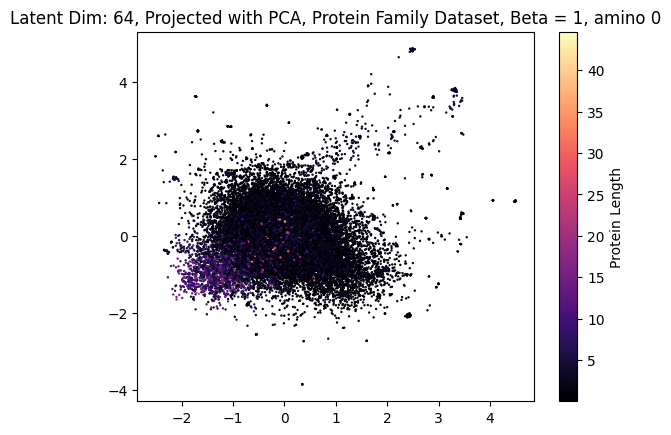

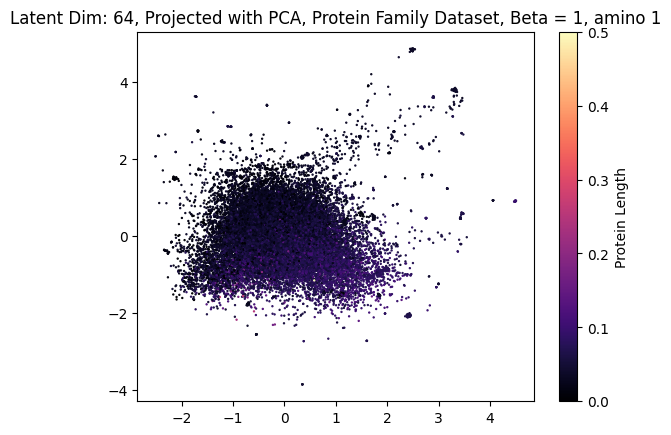

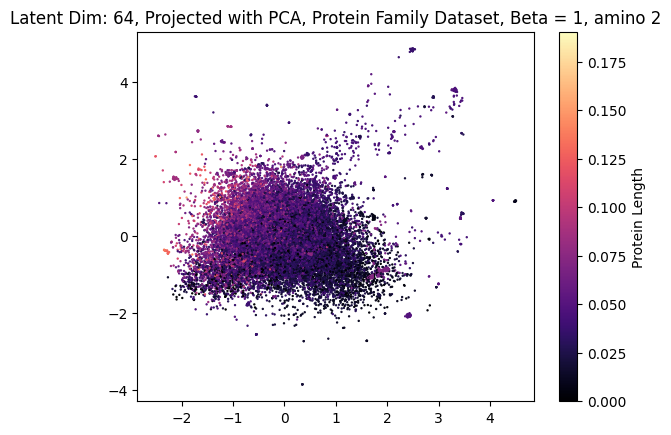

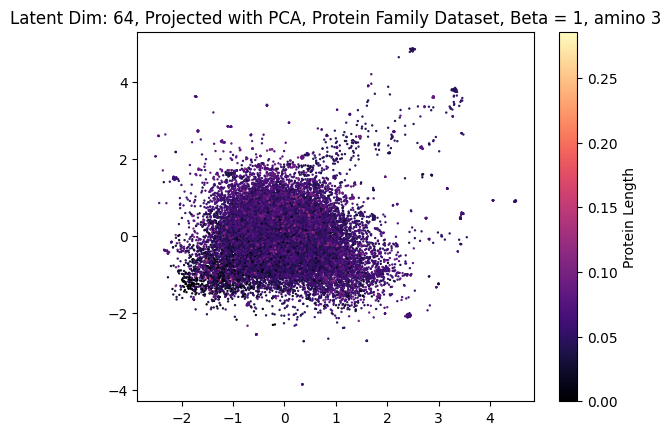

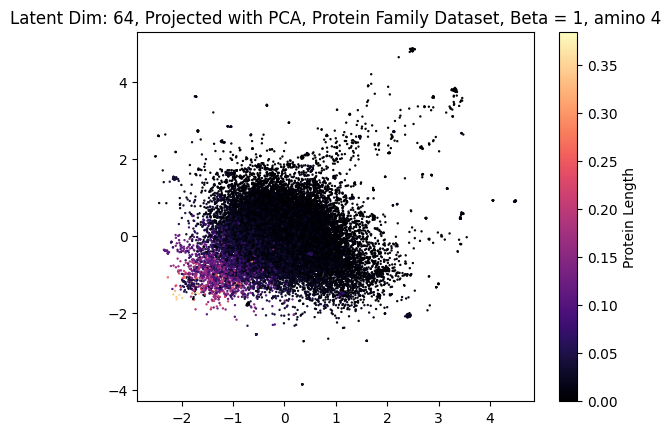

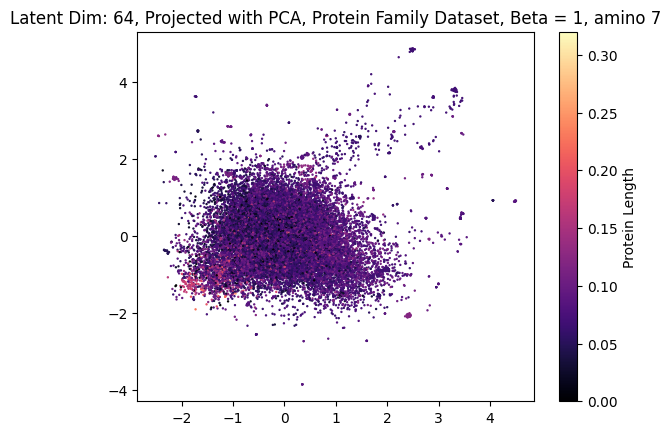

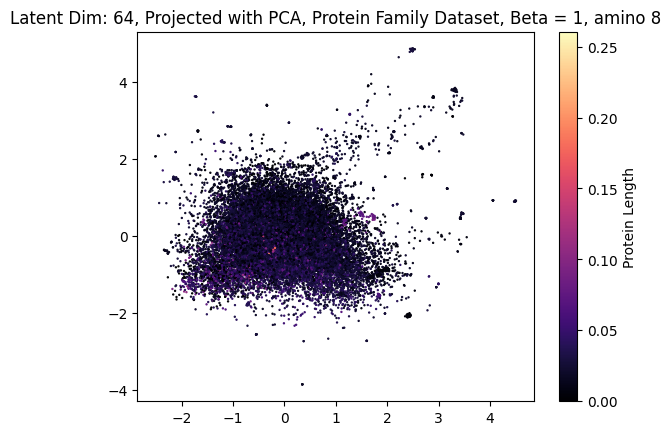

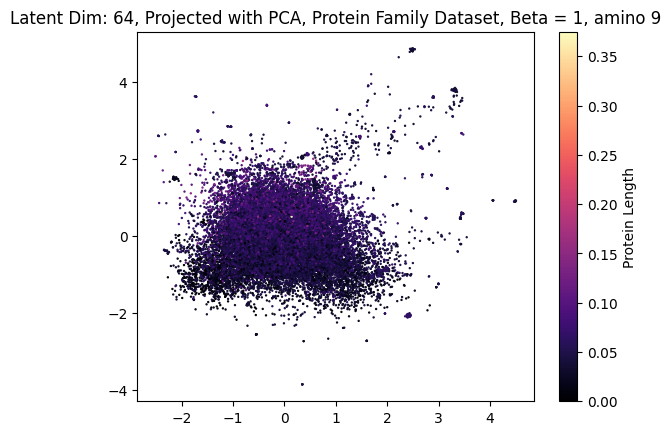

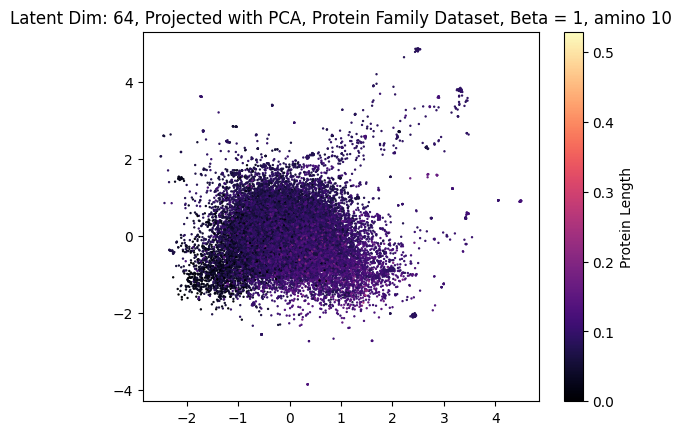

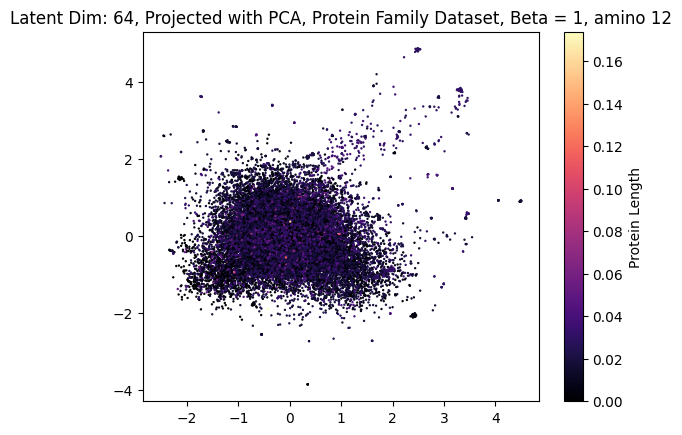

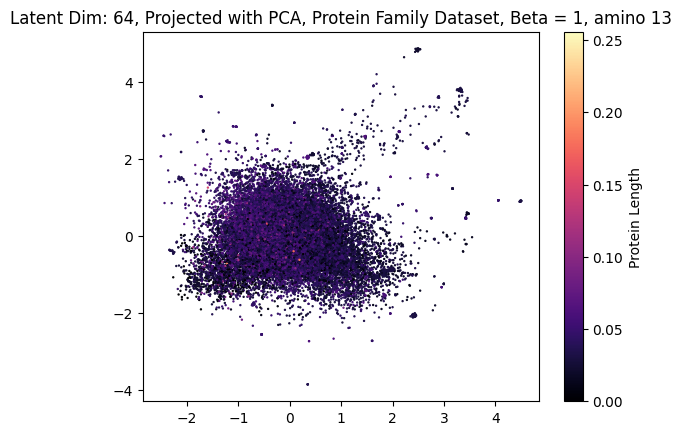

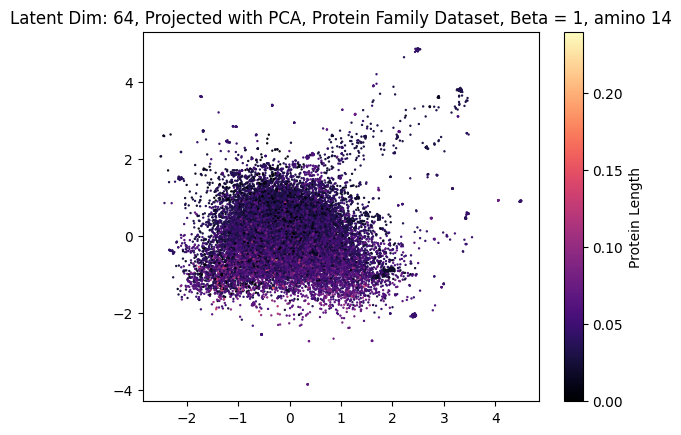

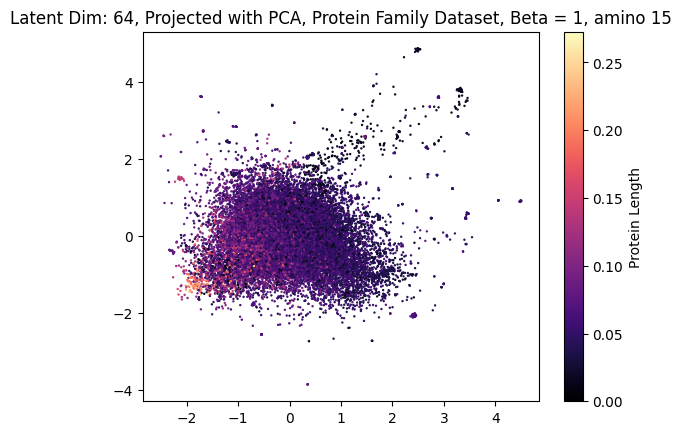

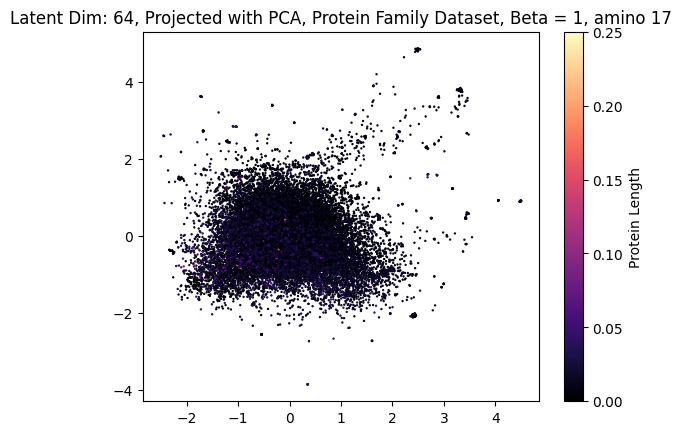

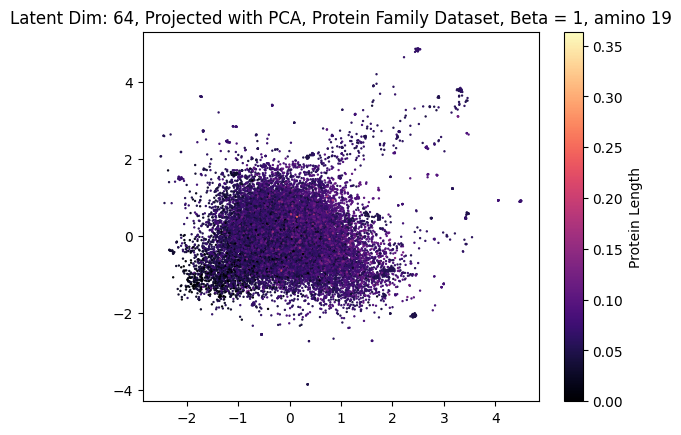

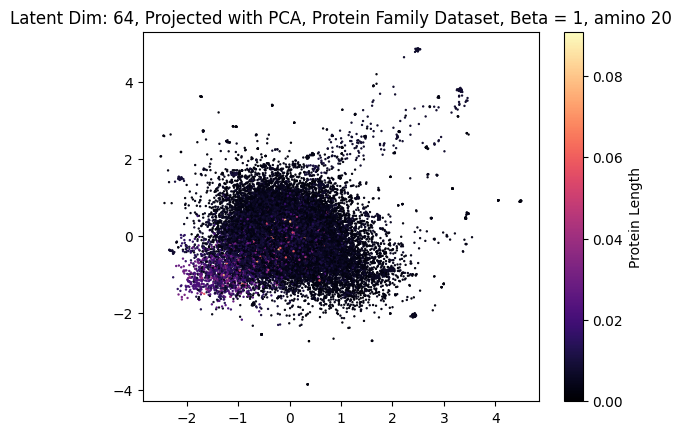

In [119]:
import matplotlib.pyplot as plt
for i in range(21):

    perc_i_amino = (torch.vstack(i_amino_count[i]).squeeze() / torch.concatenate(lengths))
    plt.scatter(projected_data[:, 0], projected_data[:, 1], s = 0.5, c=perc_i_amino.cpu().numpy(), cmap='magma')
    plt.colorbar(label = 'Protein Length')
    plt.title(f'Latent Dim: 64, Projected with PCA, Protein Family Dataset, Beta = 1, amino {i}')
    plt.show()
    # plt.savefig("exp_1_latent_Pfam.png")

The most common protein family is: PF00041


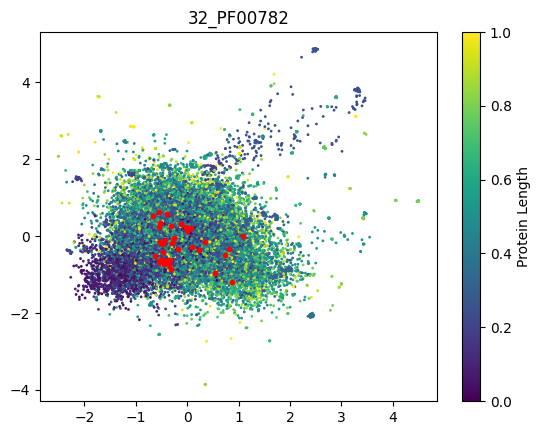

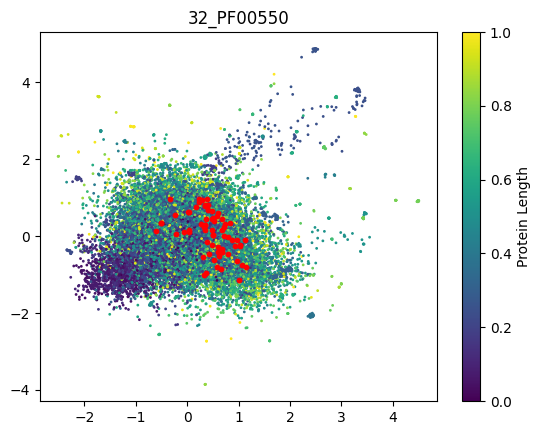

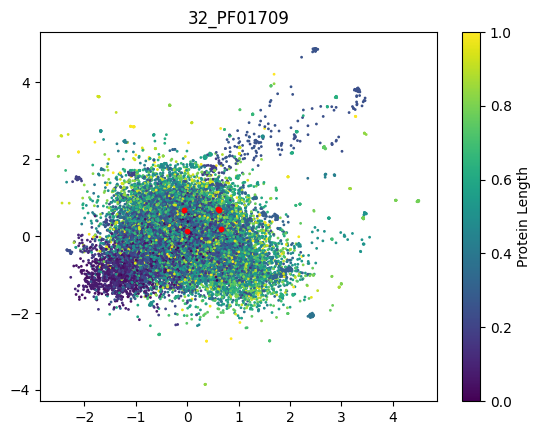

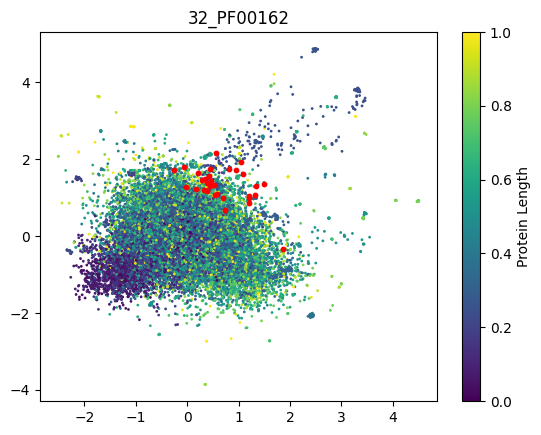

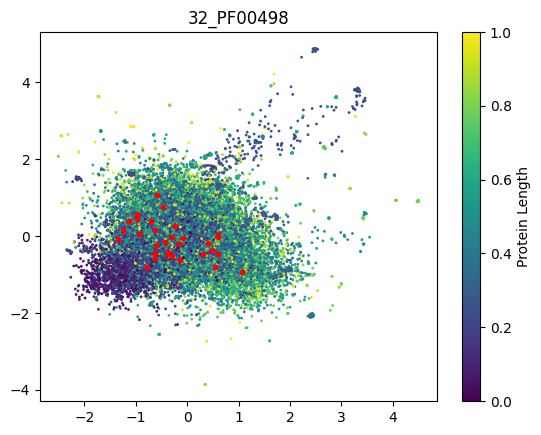

In [120]:
from collections import Counter
# Example list of strings
protein_families = families
# Count occurrences of each element
counter = Counter(protein_families)

# Get the most common element (returns a list of tuples (element, count))
most_common = counter.most_common(1)

# Extract the most common string
if most_common:
    most_common_string = 'PF00041'#most_common[0][0]  # The string of the most common element
else:
    most_common_string = None

print(f"The most common protein family is: {most_common_string}")
for i in protein_families[:10]:
    most_common_string = i
    family_array = np.array(families)
    most_common_indices = np.where((family_array == most_common_string) == 1)
    most_common_points = projected_data[most_common_indices, :]
    try:
        plt.scatter(projected_data[:, 0], projected_data[:, 1], s = 1, c=torch.concatenate(lengths), cmap='viridis')
        plt.scatter(most_common_points.squeeze()[:, 0], most_common_points.squeeze()[:, 1], s = 10, c='r')

        plt.colorbar(label = 'Protein Length')
        plt.title(f'{latent_dim}_{i}')
        plt.show()
    except:
        continue

In [64]:
counter

Counter({'PF00069': 431,
         'PF00959': 356,
         'PF07714': 286,
         'PF00565': 262,
         'PF00067': 240,
         'PF00062': 217,
         'PF00076': 198,
         'PF01353': 198,
         'PF00042': 180,
         'PF00595': 176,
         'PF00061': 171,
         'PF00071': 171,
         'PF13499': 162,
         'PF00089': 161,
         'PF00194': 160,
         'PF00096': 154,
         'PF13354': 149,
         'PF00018': 125,
         'PF00001': 119,
         'PF00041': 107,
         'PF00210': 102,
         'PF00102': 101,
         'PF00561': 99,
         'PF00072': 98,
         'PF00085': 95,
         'PF00074': 93,
         'PF07686': 92,
         'PF00248': 88,
         'PF00017': 87,
         'PF00240': 86,
         'PF00104': 85,
         'PF07679': 84,
         'PF00439': 84,
         'PF13561': 84,
         'PF00082': 79,
         'PF00141': 79,
         'PF00583': 78,
         'PF00397': 76,
         'PF00753': 74,
         'PF02518': 73,
         'PF00254'

In [121]:
from sklearn.manifold import TSNE
import numpy as np

# Example: Random high-dimensional data (e.g., 100 samples with 50 features)
data = latent_coord

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=10, n_iter=300)
tsne_results = tsne.fit_transform(data)

/opt/anaconda3/envs/ProteinManifoldLearning/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


The most common protein family is: PF00085


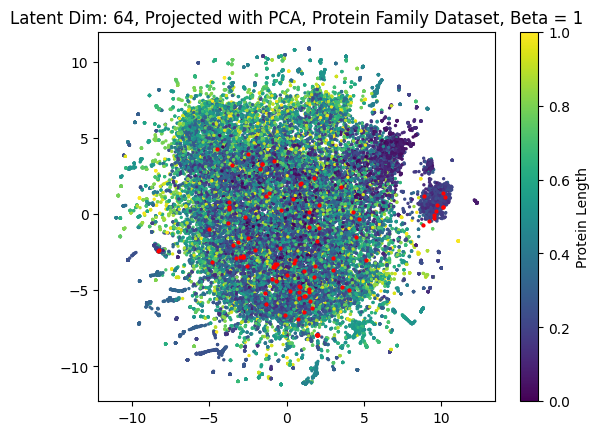

In [130]:
from sklearn.manifold import TSNE
import numpy as np

protein_families = families
# Count occurrences of each element
counter = Counter(protein_families)

# Get the most common element (returns a list of tuples (element, count))
most_common = counter.most_common(1)

# Extract the most common string
if most_common:
    most_common_string = 'PF00085'# most_common[0][0]  # The string of the most common element
else:
    most_common_string = None

print(f"The most common protein family is: {most_common_string}")

family_array = np.array(families)
most_common_indices = np.where((family_array == most_common_string) == 1)
most_common_points = tsne_results[most_common_indices, :]

plt.scatter(tsne_results[:, 0], tsne_results[:, 1], s = 2, c=torch.concatenate(lengths), cmap='viridis')
plt.scatter(most_common_points.squeeze()[:, 0], most_common_points.squeeze()[:, 1], s = 4, c='r')

plt.colorbar(label = 'Protein Length')
plt.title('Latent Dim: 64, Projected with PCA, Protein Family Dataset, Beta = 1')
plt.savefig("exp_1_latent_Pfam.png")

In [128]:
counter

Counter({'PF00069': 431,
         'PF00959': 356,
         'PF07714': 286,
         'PF00565': 262,
         'PF00067': 240,
         'PF00062': 217,
         'PF00076': 198,
         'PF01353': 198,
         'PF00042': 180,
         'PF00595': 176,
         'PF00061': 171,
         'PF00071': 171,
         'PF13499': 162,
         'PF00089': 161,
         'PF00194': 160,
         'PF00096': 154,
         'PF13354': 149,
         'PF00018': 125,
         'PF00001': 119,
         'PF00041': 107,
         'PF00210': 102,
         'PF00102': 101,
         'PF00561': 99,
         'PF00072': 98,
         'PF00085': 95,
         'PF00074': 93,
         'PF07686': 92,
         'PF00248': 88,
         'PF00017': 87,
         'PF00240': 86,
         'PF00104': 85,
         'PF07679': 84,
         'PF00439': 84,
         'PF13561': 84,
         'PF00082': 79,
         'PF00141': 79,
         'PF00583': 78,
         'PF00397': 76,
         'PF00753': 74,
         'PF02518': 73,
         'PF00254'

In [1020]:
amino_encoding_dict = {'A': 0,'R': 1,'N': 2,'D': 3,'C': 4,'E': 5,
                        'Q': 6,'G': 7,'H': 8,'I': 9,'L': 10,'K': 11,
                        'M': 12,'F': 13,'P': 14,'S': 15,'T': 16,
                        'W': 17,'Y': 18,'V': 19, 'X':20}
seq = dataset[0][1]['protein']['sequence']
string_ = torch.tensor([amino_encoding_dict[c] for c in seq])
x = torch.nn.functional.one_hot(string_, num_classes=21).float()
end_token = torch.zeros(21, dtype=x.dtype)
end_token[20] = 1
x = torch.concatenate([x, end_token.unsqueeze(0)], dim = 0)
pad_length = 500 - x.shape[0]

padded = torch.nn.functional.pad(x, (0,0,0,pad_length),"constant", 0)

In [1033]:
k = padded.argmax(dim = -1)
k[torch.where(torch.sum(padded, dim = -1) == 0)] = -1

In [1052]:
x = next(iter(train_dataloader))
k = x.argmax(dim=-1)
k[torch.where(torch.sum(x, dim = -1) == 0)] = -1
k[0]

tensor([ 0, 18,  3, 19, 10,  9, 19,  7, 15,  7, 14,  0,  7,  0,  0,  0,  0,  9,
        18, 15,  0,  1, 11,  7,  9,  1, 16,  7, 10, 12,  7,  5,  1, 13,  7,  7,
         6,  9, 10,  3, 16, 19,  3,  9,  5,  2, 18,  9, 15, 19, 14, 11, 16,  5,
         7,  6, 11, 10,  0,  7,  0, 10, 11, 19,  8, 19,  3,  5, 18,  3, 19,  3,
        19,  9,  3, 15,  6, 15,  0, 15, 11, 10,  9, 14,  0,  0, 19,  5,  7,  7,
        10,  8,  6,  9,  5, 16,  0, 15,  7,  0, 19, 10, 11,  0,  1, 15,  9,  9,
        19,  0, 16,  7,  0, 11, 17,  1,  2, 12,  2, 19, 14,  7,  5,  3,  6, 18,
         1, 16, 11,  7, 19, 16, 18,  4, 14,  8,  4,  3,  7, 14, 10, 13, 11,  7,
        11,  1, 19,  0, 19,  9,  7,  7,  7,  2, 15,  7, 19,  5,  0,  0,  9,  3,
        10,  0,  7,  9, 19,  5,  8, 19, 16, 10, 10,  5, 13,  0, 14,  5, 12, 11,
         0,  3,  6, 19, 10,  6,  3, 11, 10,  1, 15, 10, 11,  2, 19,  3,  9,  9,
        10,  2,  0,  6, 16, 16,  5, 19, 11,  7,  3,  7, 15, 11, 19, 19,  7, 10,
         5, 18,  1,  3,  1, 19, 15,  7, 

In [1041]:
torch.sum(x, dim = -1)

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])